In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
if platform.system() == 'Darwin': #맥
    plt.rc('font', family='AppleGothic') 

## 데이터 불러오기

In [31]:
subway = pd.read_csv('./subway.csv',encoding='cp949')
subway.head(5)

,날짜,호선,역번호,역명,구분,6시이전,6시-7시,7시-8시,8시-9시,9시-10시,...,14시-15시,15시-16시,16시-17시,17시-18시,18시-19시,19시-20시,20시-21시,21시-22시,22시-23시,23시이후
0,2021-01-01,1호선,150,서울역,승차,86,111,157,306,333,...,674,837,796,839,658,579,479,510,445,101
1,2021-01-01,1호선,150,서울역,하차,85,355,438,592,841,...,791,781,710,626,437,425,354,307,134,77
2,2021-01-01,1호선,151,시청,승차,43,45,75,111,95,...,189,227,233,347,294,186,216,204,110,29
3,2021-01-01,1호선,151,시청,하차,40,145,176,312,223,...,200,158,140,152,121,57,54,64,23,17
4,2021-01-01,1호선,152,종각,승차,49,59,89,126,125,...,398,513,548,504,572,492,593,513,130,31


## 서울역 승하차 인원 분석

In [98]:
subway['역명'].unique()[:10]

array(['을지로입구', '을지로3가', '을지로4가', '동대문역사문화공원(DDP)', '신당', '상왕십리',
       '왕십리(성동구청)', '한양대', '뚝섬', '성수', '건대입구', '구의(광진구청)', '강변(동서울터미널)',
       '잠실나루', '잠실(송파구청)', '잠실새내', '종합운동장', '삼성(무역센터)', '선릉', '역삼', '강남',
       '교대(법원.검찰청)', '서초', '방배', '사당', '낙성대(강감찬)', '서울대입구(관악구청)', '봉천',
       '신림', '신대방', '구로디지털단지', '대림(구로구청)', '신도림', '문래', '영등포구청', '당산',
       '합정', '홍대입구', '신촌', '이대', '아현', '충정로(경기대입구)', '용답', '신답', '도림천',
       '양천구청', '신정네거리', '용두(동대문구청)', '지축', '구파발', '연신내', '불광', '녹번', '홍제',
       '무악재', '독립문', '경복궁(정부서울청사)', '안국', '동대입구', '약수', '금호', '옥수', '압구정',
       '신사', '잠원', '고속터미널', '남부터미널(예술의전당)', '양재(서초구청)', '매봉', '도곡', '대치',
       '학여울', '대청', '일원', '수서', '가락시장', '경찰병원', '오금', '당고개', '상계', '노원',
       '창동', '쌍문', '수유(강북구청)', '미아(서울사이버대학)', '미아사거리', '길음', '성신여대입구(돈암)',
       '한성대입구(삼선교)', '혜화', '충무로', '명동', '회현(남대문시장)', '숙대입구(갈월)', '삼각지',
       '신용산', '이촌(국립중앙박물관)', '동작(현충원)', '총신대입구(이수)', '남태령', '방화', '개화산',
       '김포공항', '송정', '마곡', '발산', '우장산', '화곡', '까치산', '신

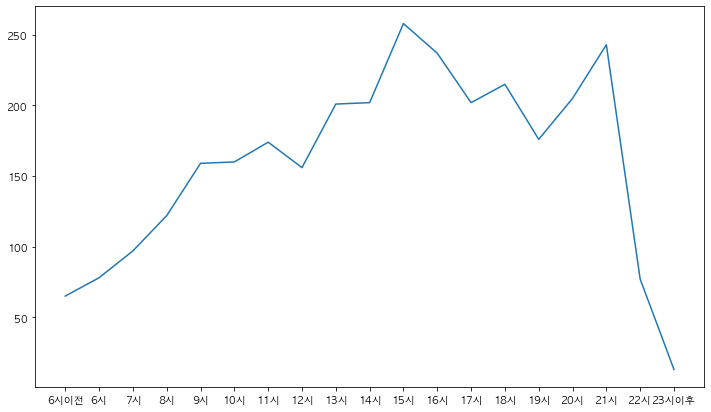

In [99]:
station = subway[subway['역명']=='부천시청']

plt.figure(figsize=(12,7))
plt.xticks(list(range(19)),[i.split('-')[0] for i in list(station.columns)[5:]])

plt.plot(list(station.iloc[0][5:]))

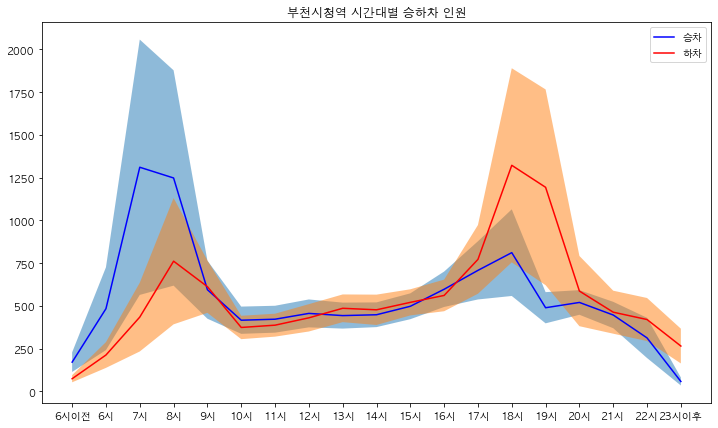

In [105]:
line = '7호선'

seoul_in  = station[(station['구분']=='승차') & (station['호선']==line)]
seoul_out = station[(station['구분']=='하차') & (station['호선']==line)]

mean_in = np.array(seoul_in[list(station.columns)[5:]]).mean(axis=0)
std_in = np.array(seoul_in[list(station.columns)[5:]]).std(axis=0)
mean_out = np.array(seoul_out[list(station.columns)[5:]]).mean(axis=0)
std_out = np.array(seoul_out[list(station.columns)[5:]]).std(axis=0)

#visualization
plt.figure(figsize=(12,7))
plt.xticks(list(range(19)),[i.split('-')[0] for i in list(seoul_station.columns)[5:]])

plt.title('부천시청역 시간대별 승하차 인원')
plt.plot(mean_in, c='blue', label='승차')
plt.fill_between(list(range(19)),mean_in-std_in,mean_in+std_in,alpha=0.5)
plt.plot(mean_out, c='red',label='하차')
plt.fill_between(list(range(19)),mean_out-std_out,mean_out+std_out,alpha=0.5)
plt.legend()